## Overview

This notebook is used to retreive USGS gauge data for the Delaware River Basin (DRB). The Hyriver suite is used to query and retrieve the data. 

First, observational records for all 

In [30]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd

# From the PyNHD library, import data acuistion tools
from pygeohydro import NWIS
import pynhd as pynhd

pywrdrb_dir = '../Pywr-DRB/'
sys.path.append(pywrdrb_dir)

from pywrdrb.pywr_drb_node_data import obs_site_matches, obs_pub_site_matches


## Get Pywrdrb-Node specific observational data

These stations correspond to nodes in the `pywrdrb` model. See the `pywrdrb.pywr_drb_node_data` for the corresponding USGS gauge IDs for each node. 


In [5]:
# Specifications
dates = ('1950-01-01', '2022-12-31')


## Get historic observations that exist
pywrdrb_stations = []
for node, sites in obs_site_matches.items():
    if len(sites) > 0:
        for s in sites:
            pywrdrb_stations.append(s)

nwis = NWIS()
Q = nwis.get_streamflow(pywrdrb_stations, dates)

# Save data
Q.index = pd.to_datetime(Q.index).date
Q.to_csv('./outputs/streamflow_daily_usgs_1950_2022_cms.csv', sep=',')

## Get USGS streamflows from across the basin

These streamflows are used later when reconstruction the historic record, to provide data for the streamflow prediction at various ungauged locations. 

One important aspect of the historic reconstruction is that the streamflow timeseries should reflect unmanaged streamflows; the `pywrdrb` model is designed to impose the effect of management on the flows. For that reason, care is taken to remove streamflow data from gauges which are heavily impacted by reservoirs. This is particularly important for any node which is located immediately downstream of a reservoir in the `pywrdrb` model, since residual management impacts, from the historic operations activities, in the provided inflow timeseries will hinder our ability to properly assess the efficacy of simulated reservoir policy. 

In [6]:
## Specifications
filter_drb = True
bbox = (-77.8, 37.5, -74.0, 44.0)
dates = ('1950-01-01', '2022-12-31')

def filter_drb_sites(x, sdir = '../Pywr-DRB/DRB_spatial/DRB_shapefiles'):
    """Filters USGS gauge data to remove gauges outside the DRB boundary.

    Args:
        x (pd.DataFrame): A dataframe with gauges including columns "long" and "lat" with location data. 
        sdir (str, optional) The location of the folder containing the DRB shapefile.
    Returns:
        pd.DataFrame: Dataframe containing gauge data, for gauges within the DRB boundary
    """
    crs = 4386

    drb_boarder = gpd.read_file(f'{sdir}/drb_bnd_polygon.shp')
    drb_boarder = drb_boarder.to_crs(crs)
    x_all = gpd.GeoDataFrame(x, geometry = gpd.points_from_xy(x.long, x.lat, crs = crs))
    x_filtered = gpd.clip(x_all, drb_boarder)
    return x_filtered

In [7]:
# Use the national water info system (NWIS)
nwis = NWIS()
print("Initialized")

# Send a query_request for all gage info in the bbox
query_request = {"bBox": ",".join(f"{b:.06f}" for b in bbox),
        "hasDataTypeCd": "dv",
        "outputDataTypeCd": "dv"}

query_result = nwis.get_info(query_request, expanded= False, nhd_info= False)

# Filter non-streamflow stations
query_result = query_result.query("site_tp_cd in ('ST','ST-TS')")
query_result = query_result[query_result.parm_cd == '00060']  # https://help.waterdata.usgs.gov/parameter_cd?group_cd=PHY
query_result = query_result.reset_index(drop = True)

stations = list(set(query_result.site_no.tolist()))
print(f"Gage data gathered, {len(stations)} USGS streamflow gauges found in date range.")


Initialized
Gage data gathered, 1393 USGS streamflow gauges found in date range.


In [8]:
### Location data (long,lat)
gage_data = query_result[['site_no', 'dec_long_va', 'dec_lat_va', 'begin_date', 'end_date']]
gage_data.columns = ['site_no', 'long', 'lat', 'begin_date', 'end_date']
gage_data.index = gage_data['site_no']
gage_data= gage_data.drop('site_no', axis=1)

# Take just locations in the DRB
if filter_drb:
    gage_data = filter_drb_sites(gage_data)
gage_data = gage_data[~gage_data.index.duplicated(keep = 'first')]
stations = gage_data.index.to_list()
print(f'{len(stations)} streamflow gauges after filtering.')


366 streamflow gauges after filtering.


### NLDI Basin Characteristic Retrieval

When estimating flows at ungauged locations, we want to use only un-managed streamflow data as reference data.  Thus, we want to remove observations from locations which are impacted by dams.  We can use the `pynhd` package to retrieve NLDI basin characteristics which tell us if a particular gauge contains dams in the basin.  

There are four catchment characteristics in the NLDI data that provide indication of reservoir operations. These are listed below. We can then use the `pynhd.NLDI()` module to access these characteristics for all DRB sites and remove any sites which have dams upstream.  

Before accessing the NLDI dataset, we need to identify the COMID for each location. This COMID is linked to the National Hydrographic Dataset (NHD). We will store these COMIDs in an metadata.

In [9]:
# Initialize the NLDI database
nldi = pynhd.NLDI()

# Get COMID for each gauge
gage_comid = pd.DataFrame(index = gage_data.index, columns=['comid', 'reachcode', 'comid-long', 'comid-lat'])
for st in gage_data.index:
    coords = (gage_data.loc[st, ['long']].values[0], gage_data.loc[st, ['lat']].values[0])
    try:
        found = nldi.comid_byloc(coords)
        gage_comid.loc[st, ['comid']] = found.comid.values[0]
        gage_comid.loc[st, ['reachcode']] = found.reachcode.values[0]
        gage_comid.loc[st, ['comid-long']] = found.geometry.x[0]
        gage_comid.loc[st, ['comid-lat']] = found.geometry.y[0]
    except:
        print(f'Error getting COMID for site {st}')
        
gage_data = pd.concat([gage_data, gage_comid], axis=1)
gage_data = gage_data.dropna(axis=0)
gage_data["comid"] = gage_data["comid"].astype('int')
gage_data.head(1)

Error getting COMID for site 01478185
Error getting COMID for site 01412080
Error getting COMID for site 01453500
Error getting COMID for site 01455200
Error getting COMID for site 01420500
Error getting COMID for site 01418000


,long,lat,begin_date,end_date,geometry,comid,reachcode,comid-long,comid-lat
site_no,,,,,,,,,
014806318,-75.833278,39.90733,1997-08-15,1998-10-29,POINT (-75.83328 39.90733),4651858,02040205000224,-75.833032,39.907284


In [11]:
# Specific characteristics of interest, for now we only want reservoir information
all_characteristics = nldi.valid_characteristics
reservoir_characteristics = ['CAT_NID_STORAGE2013', 'CAT_NDAMS2013', 'CAT_MAJOR2013', 'CAT_NORM_STORAGE2013']
TOT_reservoir_characteristics = ['TOT_NID_STORAGE2013', 'TOT_NDAMS2013', 'TOT_MAJOR2013', 'TOT_NORM_STORAGE2013']

## Use the station IDs to retrieve basin information
cat_chars = nldi.getcharacteristic_byid(gage_data.comid, fsource = 'comid', 
                                        char_type= "tot", char_ids= TOT_reservoir_characteristics)

print(f'Found characteristics for {cat_chars.shape} of {gage_data.shape} basins.')
cat = cat_chars.reset_index()
cat.columns = ['comid', 'TOT_MAJOR2013', 'TOT_NDAMS2013',	'TOT_NID_STORAGE2013',	'TOT_NORM_STORAGE2013']
cat.head(1)

In [44]:
## Make a list of known inflow gauges we want to use
obs_pub_stations = []
for node, sites in obs_pub_site_matches.items():
    if sites:
        if len(sites) > 0:
            for s in sites:
                obs_pub_stations.append(s)

## Remove sites that have reservoirs upstream
gage_with_cat_chars = pd.merge(gage_data, cat, on = "comid")
gage_with_cat_chars.index = gage_data.index
managed_stations = []
for i, st in enumerate(gage_data.index):
    if gage_with_cat_chars.loc[st, TOT_reservoir_characteristics].sum() > 0:
        if st not in obs_pub_stations:
            managed_stations.append(st)

# Take data from just unmanaged
unmanaged_gauge_data = gage_data.drop(managed_stations)
print(f'{len(managed_stations)} of the {gage_data.shape[0]} gauge stations is managed in some way.')

# Export gage_data
gage_data.to_csv('./data/drb_all_usgs_metadata.csv', sep=',')
unmanaged_gauge_data.to_csv('./data/drb_unmanaged_usgs_metadata.csv', sep=',')

226 of the 360 gauge stations is managed in some way.


### Retrieve streamflow for unmanaged gauges

Now that we have identified all the stations that are (1) within the DRB watershed and (2) not heavily managed, we can retrieve the streamflow timeseries for each of those stations and save the data. 

In [45]:
# Date range of data to be retrieved
dates = ('1900-01-01', '2023-06-01')

# Retrieve data using NWIS
stations = unmanaged_gauge_data.index
nwis = NWIS()
Q = nwis.get_streamflow(stations, dates)

# Export all data to CSV
Q.to_csv(f'./data/historic_unmanaged_streamflow_{dates[0][:4]}_{dates[1][:4]}_cms.csv', sep=',')

## Done!

The data is now available for the historic reconstruction. Go to the `QPPQ_Demo.ipynb` for the next step.

In [56]:
import matplotlib.pyplot as plt

prediction_locations = pd.read_csv(f'./data/prediction_locations.csv', sep = ',', index_col=0)
prediction_locations = gpd.GeoDataFrame(prediction_locations, geometry=gpd.points_from_xy(prediction_locations.long, prediction_locations.lat))

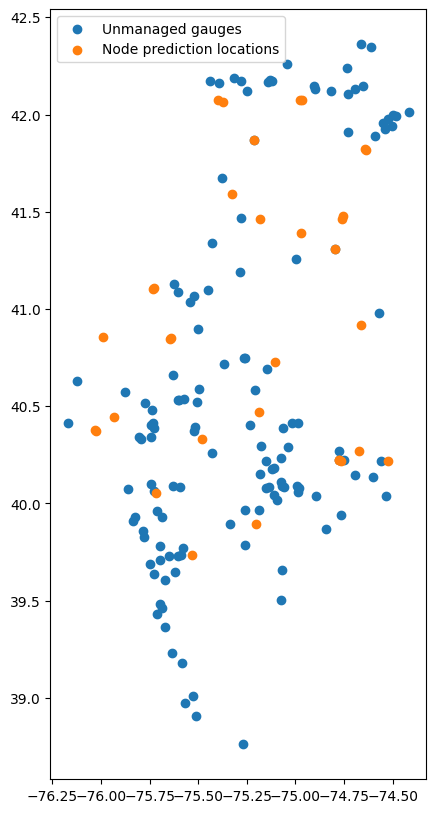

In [57]:
ax = unmanaged_gauge_data.plot(figsize = (10,10), label = 'Unmanaged gauges')
prediction_locations.plot(ax=ax, label = 'Node prediction locations')
plt.legend()